# Load the Dataset in Python

In [59]:
import pandas as pd

# Load dataset
df = pd.read_csv("dataset.csv")

# Check the first few rows
df.head()

,event_id,session_id,user_id,variation,platform,datetime_event,event_type,final_order_status,shop_id
0,63527610,6391574,762832,2,Android,2024-11-30 16:23:46.391133804,entry_to_shop,successful,8531.0
1,12446736,6391574,762832,2,Android,2024-11-30 16:26:16.875713965,order_paid,successful,8531.0
2,90232698,6391574,762832,2,Android,2024-11-30 16:50:44.827088753,order_finished,successful,8531.0
3,74183469,9246026,762832,2,Android,2024-11-29 13:21:28.729203894,reload_the_page,NaN,6186.0
4,16360628,9246026,762832,2,Android,2024-11-29 13:21:35.213637901,entry_to_shop,NaN,6186.0


# Check for Missing Values & Data Types

In [62]:
# Check for missing values
print(df.isnull().sum())

# Check data types
print(df.dtypes)

event_id                   0
session_id                 0
user_id                    0
variation                  0
platform                   0
datetime_event             0
event_type                 0
final_order_status    156289
shop_id                11079
dtype: int64
event_id                int64
session_id              int64
user_id                 int64
variation               int64
platform               object
datetime_event         object
event_type             object
final_order_status     object
shop_id               float64
dtype: object


# Handling Missing Values

In [66]:
df.dropna(subset=['shop_id'], inplace=True)

shop_id is not critical, so i choose to drop this rows 

In [69]:
df['final_order_status'] = df['final_order_status'].fillna("no_order")

final_order_status (156,289 missing values)

This likely means that many users did not complete an order.

If final_order_status is only available for completed orders (e.g., “successful" "cancelled" "refunded_after_delivery”), here I made an assumption that missing values represent "no order placed". So Filling missing values with "no_order".

# Fixing Data Types
Converting datetime_event to Datetime Format
Right now, it’s object (string). Need it in datetime format for time-based analysis.

In [72]:
df['datetime_event'] = pd.to_datetime(df['datetime_event'])

In [74]:
print(df['final_order_status'].isnull().sum())  # Should print 0
print(df['final_order_status'].value_counts())  # Check distribution of values

0
final_order_status
successful                 146035
no_order                   145210
cancelled                   17199
refunded_after_delivery      7398
Name: count, dtype: int64


In [76]:
# Check for missing values
print(df.isnull().sum())

# Check data types
print(df.dtypes)

event_id              0
session_id            0
user_id               0
variation             0
platform              0
datetime_event        0
event_type            0
final_order_status    0
shop_id               0
dtype: int64
event_id                       int64
session_id                     int64
user_id                        int64
variation                      int64
platform                      object
datetime_event        datetime64[ns]
event_type                    object
final_order_status            object
shop_id                      float64
dtype: object


# User Distribution Across Variations

User Count per Variation:
variation
1    205338
2    110504
Name: count, dtype: int64


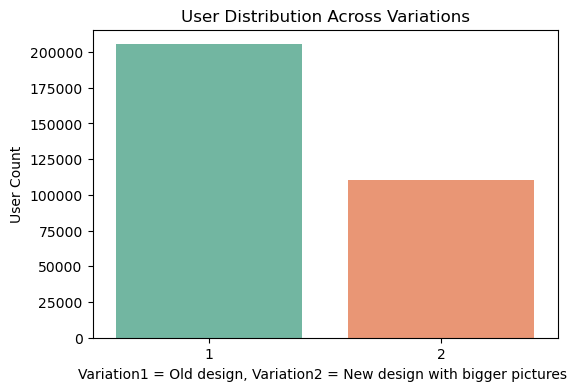

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns

# Print exact counts
variation_counts = df['variation'].value_counts()
print("User Count per Variation:")
print(variation_counts)

# Countplot for user distribution
plt.figure(figsize=(6,4))
sns.countplot(x='variation', data=df, hue='variation', palette='Set2', legend=False)
plt.title("User Distribution Across Variations")
plt.xlabel("Variation1 = Old design, Variation2 = New design with bigger pictures)")
plt.ylabel("User Count")
plt.show()

User distribution across variations is imbalanced:

Variation 1 (Old Design) → 205,338 users
Variation 2 (New Design) → 110,504 users

A/B tests should ideally have a balanced distribution of users across variations.

If one group has significantly more users, results might be biased.
Any observed differences in conversion rates could be due to unequal sample sizes rather than the UI change itself.

# Resample the Data for Balance
Here I am randomly downsample Variation 1 to match Variation 2’s user count.

In [88]:
# Downsample Variation 1 to match Variation 2
df_v1 = df[df['variation'] == 1].sample(n=110504, random_state=42)
df_v2 = df[df['variation'] == 2]

# Merge the balanced dataset
df_balanced = pd.concat([df_v1, df_v2])

# Print new counts
print("Balanced User Count per Variation:")
print(df_balanced['variation'].value_counts())

Balanced User Count per Variation:
variation
1    110504
2    110504
Name: count, dtype: int64


# Calculate Conversion Rates
Compute Conversion Rate for Each Variation

In [53]:
# Count total users in each variation
total_users = df_balanced['variation'].value_counts()

# Count successful orders in each variation
successful_orders = df_balanced[df_balanced['final_order_status'] == 'successful']['variation'].value_counts()

# Calculate conversion rates
conversion_rates = (successful_orders / total_users) * 100  # Convert to percentage

# Print results
print("Conversion Rates per Variation:")
print(conversion_rates)


Conversion Rates per Variation:
variation
1    45.523239
2    47.756642
Name: count, dtype: float64


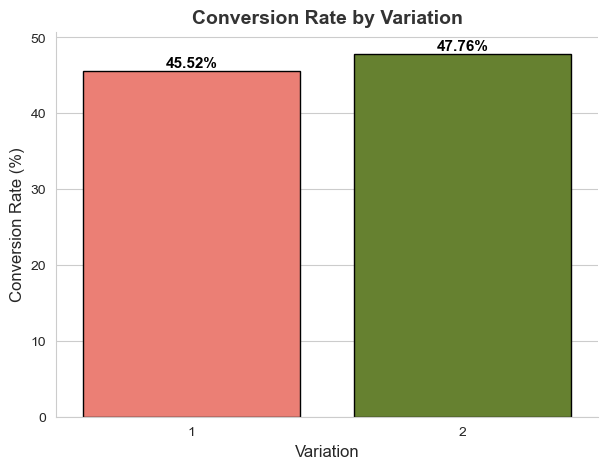

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set modern style
sns.set_style("whitegrid")  
plt.figure(figsize=(7,5))

# Custom color palette
colors = ["#FF6F61", "#6B8E23"]  # Red & Olive Green

# Create barplot with proper `hue`
sns.barplot(x=conversion_rates.index, y=conversion_rates.values, hue=conversion_rates.index, 
            palette=colors, legend=False, edgecolor="black")

# Titles & labels
plt.title("Conversion Rate by Variation", fontsize=14, fontweight="bold", color="#333")
plt.xlabel("Variation", fontsize=12)
plt.ylabel("Conversion Rate (%)", fontsize=12)

# Annotate bars with values
for i, value in enumerate(conversion_rates.values):
    plt.text(i, value + 0.5, f"{value:.2f}%", ha='center', fontsize=11, fontweight="bold", color="black")

# Remove unnecessary borders
sns.despine()

plt.ylim(0, max(conversion_rates.values) + 3)  # Adjust y-axis
plt.show()

In [95]:
print("Total Users per Variation:")
print(total_users)

print("\nSuccessful Orders per Variation:")
print(successful_orders)

Total Users per Variation:
variation
1    110504
2    110504
Name: count, dtype: int64

Successful Orders per Variation:
variation
2    52773
1    50305
Name: count, dtype: int64


# Key Observations:
The New Design Has a Higher Conversion Rate

Old Design: 45.52% of users placed a successful order.
New Design: 47.76% of users placed a successful order.
This suggests that the new design with bigger images led to a 2.24% improvement in conversion rate.
Absolute Increase in Successful Orders

2,468 more successful orders were placed in the new design compared to the old one.
This could translate to a significant increase in revenue, depending on the average order value.
User Engagement Remained Consistent

Since total users were balanced (110,504 each), the results are fair, and the improvement in orders is likely due to the design change, not sample size differences.

# Check Overall Order Status Distribution
First, let's see how many orders fall into different categories (successful, cancelled, refunded_after_delivery, no_order).

Order Status Counts:
     final_order_status  count
             successful 103078
               no_order 101589
              cancelled  12135
refunded_after_delivery   4206


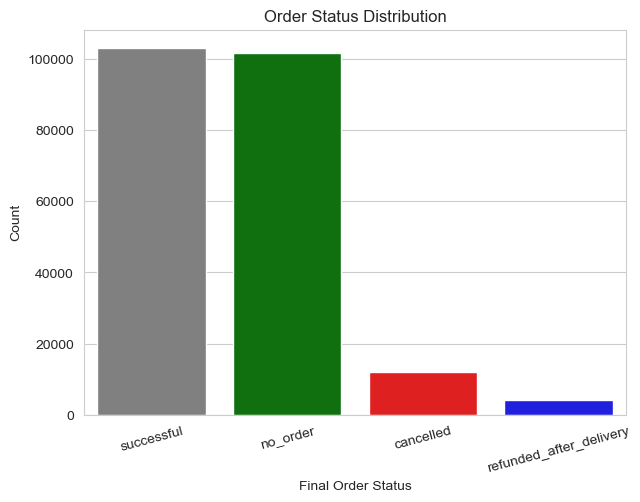

In [103]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count of each order status
order_status_counts = df_balanced['final_order_status'].value_counts().reset_index()
order_status_counts.columns = ['final_order_status', 'count']  # Rename columns for clarity

# Print exact counts
print("Order Status Counts:")
print(order_status_counts.to_string(index=False))  # Display without index

# Bar plot for order status distribution
plt.figure(figsize=(7, 5))
sns.barplot(
    x='final_order_status',
    y='count',
    hue='final_order_status',  # Assign hue to x-variable
    data=order_status_counts,
    palette=['gray', 'green', 'red', 'blue'],
    legend=False  # Remove redundant legend
)
plt.title("Order Status Distribution")
plt.xlabel("Final Order Status")
plt.ylabel("Count")
plt.xticks(rotation=15)  # Rotate labels for readability
plt.show()

# Compare Order Status Across Variations
Now, let’s check how order statuses differ between the old (1) and new (2) designs.

In [108]:
# Count of order statuses per variation
order_status_by_variation = df_balanced.groupby(['variation', 'final_order_status']).size().unstack()

# Print result
print("Order Status Breakdown by Variation:")
print(order_status_by_variation)

Order Status Breakdown by Variation:
final_order_status  cancelled  no_order  refunded_after_delivery  successful
variation                                                                   
1                        5940     50611                     3648       50305
2                        6195     50978                      558       52773


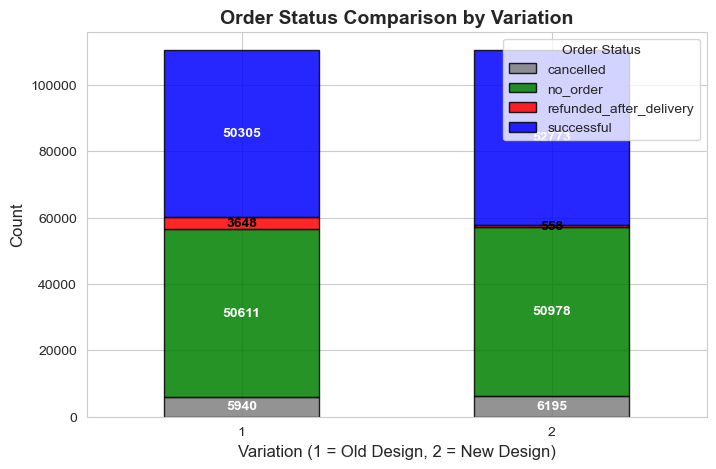

In [120]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better aesthetics
sns.set_style("whitegrid")

# Define color palette
colors = ['gray', 'green', 'red', 'blue']

# Plot stacked bar chart
fig, ax = plt.subplots(figsize=(8, 5))
order_status_by_variation.plot(
    kind='bar',
    stacked=True,
    color=colors,
    alpha=0.85,  # Make bars slightly transparent
    edgecolor='black',  # Add borders for better readability
    ax=ax
)

# Titles and labels
plt.title("Order Status Comparison by Variation", fontsize=14, fontweight='bold')
plt.xlabel("Variation (1 = Old Design, 2 = New Design)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=0)
plt.legend(title="Order Status", loc="upper right")

# Add percentage labels on bars
for i, bars in enumerate(ax.containers):
    for bar in bars:
        height = bar.get_height()
        if height > 0:  # Avoid labeling zero values
            ax.text(
                bar.get_x() + bar.get_width() / 2, 
                bar.get_y() + height / 2, 
                f"{int(height)}", 
                ha='center', 
                va='center', 
                fontsize=10, 
                fontweight='bold', 
                color='white' if height > order_status_by_variation.values.max() * 0.1 else 'black'
            )

# Show plot
plt.show()

# Key Observations:
Successful Orders Increased in the New Design

The new design (Variation 2) led to 52,773 successful orders, compared to 50,305 in the old design.
This suggests that larger food images may positively impact conversion rates.
No Significant Change in "No Order" Cases

The number of users who did not place an order is almost the same (50,611 vs. 50,978).
This indicates that larger images did not influence indecisive users much.
Cancellation Rate is Slightly Higher in the New Design

More cancellations occurred in the new design (6,195 vs. 5,940).
This could mean that users were more impulsive in ordering but later changed their mind.
Drastic Drop in Refunds After Delivery

In the new design, refunds after delivery dropped significantly from 3,648 to 558.
This suggests that customers may have been more satisfied with their orders, possibly because larger images set better expectations about the food.

# Statistical Testing
Now, we will statistically validate whether the new design (Variation 2) significantly improves conversions.

Step 1: Chi-Square Test for Conversion Rate
This test determines if the increase in conversion rate (from 45.52% to 47.75%) is statistically significant or just due to randomness.

Null Hypothesis (H₀): No difference in conversion rates between Variation 1 & Variation 2.
Alternative Hypothesis (H₁): Conversion rates are different for Variation 1 & 2.
👉 Steps
Create a contingency table for successful orders vs. total users.
Perform a Chi-Square Test.
Interpret p-value:
p < 0.05 → Reject H₀ → UI change significantly improves conversions ✅
p > 0.05 → Fail to reject H₀ → No significant impact ❌

In [140]:
import scipy.stats as stats

# Create contingency table
conversion_table = pd.DataFrame({
    "Successful Orders": df_balanced[df_balanced['final_order_status'] == 'successful']['variation'].value_counts(),
    "Total Users": df_balanced['variation'].value_counts()
})

# Add Failed Orders (Total - Successful)
conversion_table['Failed Orders'] = conversion_table['Total Users'] - conversion_table['Successful Orders']

# Perform Chi-Square Test
chi2, p, dof, expected = stats.chi2_contingency(conversion_table[['Successful Orders', 'Failed Orders']])

# Print results
print(f"Chi-Square Statistic: {chi2:.4f}")
print(f"P-value: {p:.4f}")

# Interpretation
if p < 0.05:
    print("✅ The result is statistically significant. The UI change improves conversion rates.")
else:
    print("❌ No significant difference. The UI change does not impact conversion rates.")

Chi-Square Statistic: 110.6512
P-value: 0.0000
✅ The result is statistically significant. The UI change improves conversion rates.


# Interpretation of Chi-Square Test Results
Key Findings:
Chi-Square Statistic = 110.6512
P-value = 0.0000 (which is < 0.05)

Conclusion: The difference in conversion rates between Variation 1 (Old Design) and Variation 2 (New Design) is statistically significant.

Practical Meaning: The UI change positively impacts conversions, making it a better design choice.


🔹 Conversion Summary per Variation:
           Successful Orders  Total Users  Conversion Rate (%)
variation                                                     
1                      50305       110504            45.523239
2                      52773       110504            47.756642


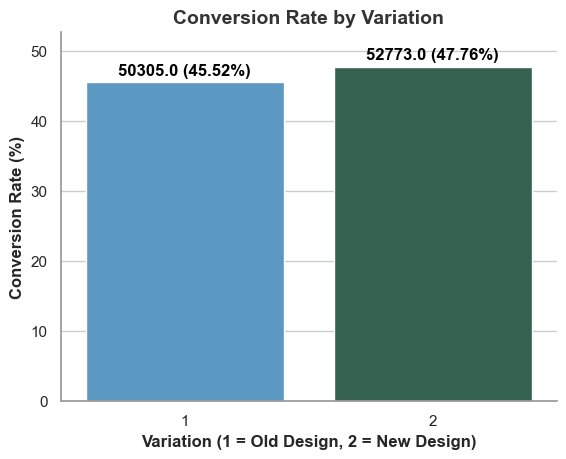

In [199]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate total users per variation
total_users = df_balanced['variation'].value_counts().sort_index()

# Count successful orders per variation
successful_orders = df_balanced[df_balanced['final_order_status'] == 'successful']['variation'].value_counts().sort_index()

# Create a DataFrame for better presentation
conversion_summary = (
    successful_orders.to_frame(name='Successful Orders')
    .join(total_users.to_frame(name='Total Users'))
    .fillna(0)  # Fill missing values with 0
)

# Ensure index ordering is consistent
conversion_summary = conversion_summary.sort_index()

# Compute conversion rates
conversion_summary['Conversion Rate (%)'] = (conversion_summary['Successful Orders'] / conversion_summary['Total Users']) * 100

# Print exact counts
print("\n🔹 Conversion Summary per Variation:")
print(conversion_summary)

# Set a modern style
sns.set_theme(style="whitegrid")

# Bar plot with correct ordering and hue assignment
ax = sns.barplot(
    x=conversion_summary.index.astype(str),  # Ensure variations are categorical
    y=conversion_summary['Conversion Rate (%)'],
    hue=conversion_summary.index.astype(str),  # Assign hue properly
    palette=colors,
    dodge=False
)

# Disable the legend explicitly
plt.legend([], [], frameon=False)
plt.title("Conversion Rate by Variation", fontsize=14, fontweight='bold', color="#333")
plt.xlabel("Variation (1 = Old Design, 2 = New Design)", fontsize=12, fontweight='bold')
plt.ylabel("Conversion Rate (%)", fontsize=12, fontweight='bold')
plt.ylim(0, max(conversion_summary['Conversion Rate (%)']) + 5)  # Add space for labels
plt.xticks(fontsize=11)

# Display exact counts and percentages on bars
for index, value in enumerate(conversion_summary['Conversion Rate (%)']):
    count = conversion_summary.iloc[index]['Successful Orders']
    ax.text(index, value + 1, f"{count} ({value:.2f}%)", ha='center', fontsize=12, fontweight='bold', color="black")

# Remove unnecessary legend
plt.legend([], [], frameon=False)

# Add a border around the plot
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["left"].set_color("#999")
plt.gca().spines["bottom"].set_color("#999")

plt.show()

# Interpretation of Conversion Summary
Variation 2 (New Design) has a Higher Conversion Rate

47.76% conversion compared to 45.52% in Variation 1.
    
This suggests the new design led to a higher percentage of successful orders.

More Successful Orders in Variation 2

52,773 successful orders in Variation 2 vs. 50,305 in Variation 1.
Even though both variations had the same number of total users (110,504 each), the new design resulted in ~2.23% more conversions.

# Two-Proportion Z-Test


🔹 Two-Proportion Z-Test Results:
Z-Statistic: -10.5233
P-value: 0.0000
✅ Statistically significant difference in conversion rates.


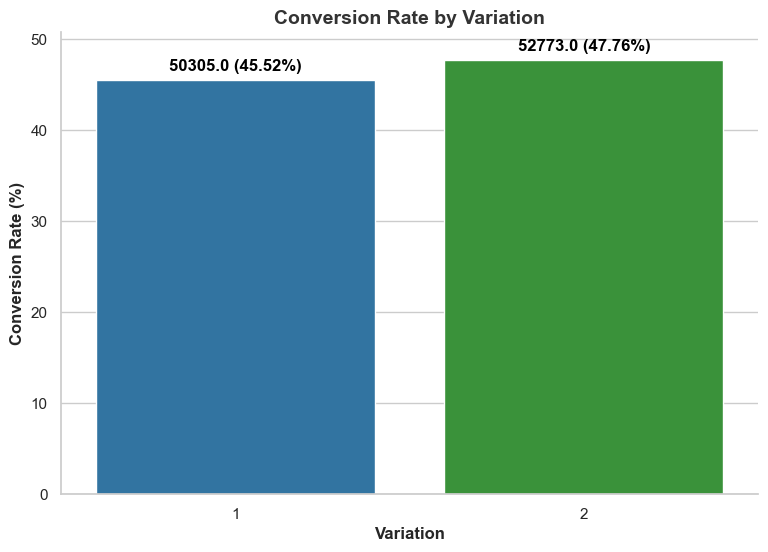

In [201]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate total users per variation
total_users = df_balanced['variation'].value_counts()

# Count successful orders per variation
successful_orders = df_balanced[df_balanced['final_order_status'] == 'successful']['variation'].value_counts()

# Create a DataFrame for better presentation
conversion_summary = (
    successful_orders.to_frame(name='Successful Orders')
    .join(total_users.to_frame(name='Total Users'))
    .fillna(0)  # Fill missing values with 0
)

# Ensure variations are in correct order (1 first, then 2)
conversion_summary = conversion_summary.sort_index()

# Compute Conversion Rate
conversion_summary['Conversion Rate (%)'] = (conversion_summary['Successful Orders'] / conversion_summary['Total Users']) * 100

# Extract values for Z-Test
successful_orders_arr = conversion_summary['Successful Orders'].values
total_users_arr = conversion_summary['Total Users'].values

# Perform Two-Proportion Z-Test
z_stat, p_value = sm.stats.proportions_ztest(successful_orders_arr, total_users_arr, alternative='two-sided')

# Print Results
print("\n🔹 Two-Proportion Z-Test Results:")
print(f"Z-Statistic: {z_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# Interpretation
if p_value < 0.05:
    print("✅ Statistically significant difference in conversion rates.")
else:
    print("❌ No statistically significant difference in conversion rates.")

# 🔹 Visualization: Improved Bar Chart with Correct Order
plt.figure(figsize=(9, 6))
colors = ['#1f77b4', '#2ca02c']  # Blue for Variation 1, Green for Variation 2

ax = sns.barplot(
    x=conversion_summary.index.astype(str),  # Ensure variations are categorical
    y=conversion_summary['Conversion Rate (%)'],
    hue=conversion_summary.index.astype(str),  # Assign hue correctly
    palette=colors,
    dodge=False
)

# Title & Labels
plt.title("Conversion Rate by Variation", fontsize=14, fontweight='bold', color="#333")
plt.xlabel("Variation", fontsize=12, fontweight='bold')
plt.ylabel("Conversion Rate (%)", fontsize=12, fontweight='bold')
plt.ylim(0, max(conversion_summary['Conversion Rate (%)']) + 3)  # Adjust for better spacing

# Add percentage labels on bars
for index, value in enumerate(conversion_summary['Conversion Rate (%)']):
    count = conversion_summary.iloc[index]['Successful Orders']
    ax.text(index, value + 1, f"{count} ({value:.2f}%)", ha='center', fontsize=12, fontweight='bold', color="black")

# Remove unnecessary legend
plt.legend([], [], frameon=False)

# Enhance appearance (Remove top/right border)
sns.despine()

plt.show()

# Interpretation of Results
Z-Statistic: -10.5233

A large negative Z-score means that the conversion rate of Variation 1 is significantly lower than Variation 2.

P-value: 0.0000

Since p < 0.05, we reject the null hypothesis (H₀).

This confirms that the difference in conversion rates is not due to randomness.

Conclusion: The new design (Variation 2) significantly improves conversions compared to the old design.

# Bounce Rate Calculation

🔹 Bounce Rate: 38.46%


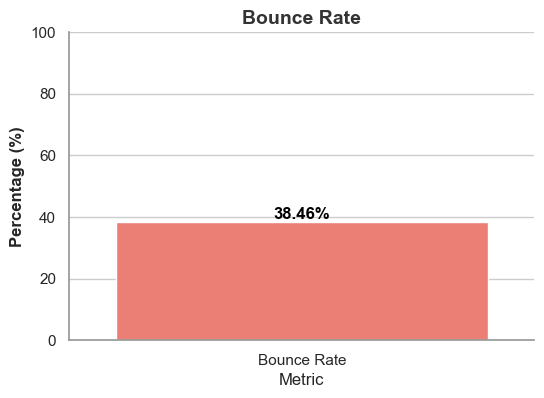

In [223]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure 'user_id' and 'event_type' exist in the dataset
if 'user_id' in df.columns and 'event_type' in df.columns:
    # Step 1: Identify users who performed only one unique event (Bounced Users)
    bounced_users = df.groupby('user_id')['event_type'].nunique().reset_index()
    bounced_users = bounced_users[bounced_users['event_type'] == 1]  # Only 1 unique event

    # Step 2: Calculate Bounce Rate
    bounce_rate = (len(bounced_users) / df['user_id'].nunique()) * 100
    print(f"🔹 Bounce Rate: {bounce_rate:.2f}%")

    # Step 3: Create a DataFrame for visualization
    bounce_data = pd.DataFrame({'Metric': ['Bounce Rate'], 'Value': [bounce_rate]})

    # Step 4: Set Theme
    sns.set_theme(style="whitegrid")

    # Step 5: Create Bar Plot (Fixes FutureWarning)
    plt.figure(figsize=(6, 4))
    ax = sns.barplot(
        x='Metric', 
        y='Value', 
        data=bounce_data, 
        hue='Metric',  # Assign hue correctly
        palette={'Bounce Rate': '#ff6f61'}, 
        legend=False  # Remove the legend
    )

    # Step 6: Display Percentage on the Bar
    for index, value in enumerate(bounce_data['Value']):
        ax.text(index, value + 1, f"{value:.2f}%", ha='center', fontsize=12, fontweight='bold', color="black")

    # Step 7: Formatting
    plt.title("Bounce Rate", fontsize=14, fontweight='bold', color="#333")
    plt.ylabel("Percentage (%)", fontsize=12, fontweight='bold')
    plt.ylim(0, 100)  # Set limit to 100% for clarity

    # Remove unnecessary spines
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.gca().spines["left"].set_color("#999")
    plt.gca().spines["bottom"].set_color("#999")

    # Step 8: Show Plot
    plt.show()

# Conclusion on Bounce Rate
Bounce Rate Interpretation:

Calculated bounce rate is 38.46%.

This means that 38.46% of users left without taking any meaningful action after their first interaction.

Possible Reasons for a High Bounce Rate:

Unengaging UI/UX – Users might not find the design appealing or intuitive.

Irrelevant content – The landing page may not align with user expectations.

Slow loading times – If the page or app is slow, users may abandon it.

Confusing navigation – Users might struggle to find what they need.

# Order Completion Rate → (Successful orders / Total orders)

🔹 Order Completion Rate: 85.58%


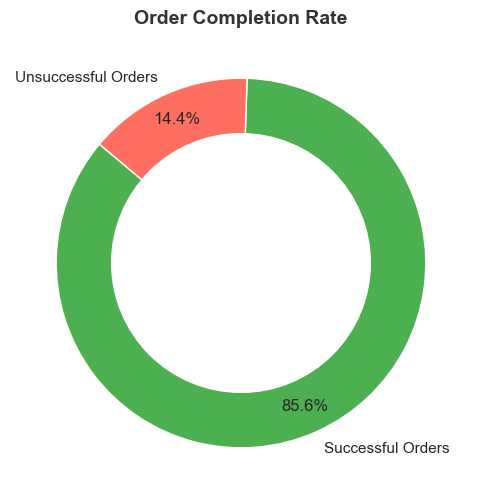

In [236]:
import matplotlib.pyplot as plt

# Count total orders (all final order statuses)
total_orders = df['final_order_status'].count()

# Count successful orders
successful_orders = df[df['final_order_status'] == 'successful'].shape[0]

# Calculate order completion rate
order_completion_rate = (successful_orders / total_orders) * 100

print(f"🔹 Order Completion Rate: {order_completion_rate:.2f}%")

# Count failed orders
failed_orders = total_orders - successful_orders  # Orders that were not successful

# Define labels and values
labels = ['Successful Orders', 'Unsuccessful Orders']
sizes = [successful_orders, failed_orders]
colors = ['#4CAF50', '#FF6F61']  # Green for success, red for unsuccessful

# Create the pie chart (donut)
plt.figure(figsize=(6, 6))
wedges, texts, autotexts = plt.pie(
    sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=140,
    wedgeprops={'edgecolor': 'white'}, pctdistance=0.85
)

# Draw a white circle at the center to make it a donut chart
center_circle = plt.Circle((0, 0), 0.70, fc='white')
plt.gca().add_artist(center_circle)

# Title and styling
plt.title("Order Completion Rate", fontsize=14, fontweight='bold', color="#333")

# Display chart
plt.show()

# Bounce Rate by Platform

🔹 Android Bounce Rate: 39.17%
🔹 iOS Bounce Rate: 36.80%


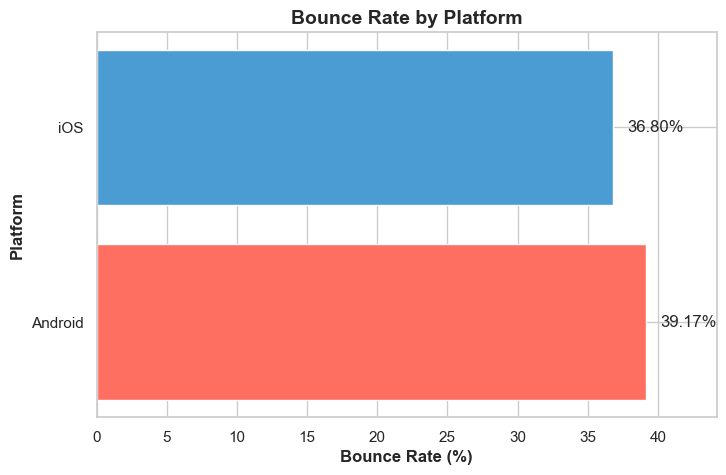

In [268]:
import matplotlib.pyplot as plt

# Step 1: Calculate total unique users per platform
total_users_platform = df.groupby('platform')['user_id'].nunique()

# Step 2: Identify bounced users (users with only one unique event)
bounced_users = df.groupby('user_id')['event_type'].nunique()
bounced_users = bounced_users[bounced_users == 1].index  # Users who had only 1 event

# Step 3: Count bounced users per platform
bounced_users_platform = df[df['user_id'].isin(bounced_users)].groupby('platform')['user_id'].nunique()

# Step 4: Calculate bounce rate per platform
bounce_rate_platform = (bounced_users_platform / total_users_platform) * 100
bounce_rate_platform = bounce_rate_platform.fillna(0)  # Replace NaN with 0 if any platform is missing

# Convert to DataFrame
bounce_df = bounce_rate_platform.reset_index()
bounce_df.columns = ['Platform', 'Bounce Rate (%)']

# ✅ Debug: Print actual values for verification
for platform, rate in zip(bounce_df['Platform'], bounce_df['Bounce Rate (%)']):
    print(f"🔹 {platform} Bounce Rate: {rate:.2f}%")

# ✅ Ensure Correct Pie Chart Representation
sizes = bounce_df['Bounce Rate (%)'].values  # Use the actual bounce rate percentages

# Merge bounce rate with the original dataframe for platform grouping
df_bounce = df[df['user_id'].isin(bounced_users)].copy()
df_bounce['Bounce Rate'] = df_bounce['platform'].map(bounce_rate_platform)

import matplotlib.pyplot as plt

# Create a horizontal bar chart
plt.figure(figsize=(8, 5))
plt.barh(bounce_df['Platform'], bounce_df['Bounce Rate (%)'], color=['#FF6F61', '#4B9CD3'])

# Add text labels
for index, value in enumerate(bounce_df['Bounce Rate (%)']):
    plt.text(value + 1, index, f"{value:.2f}%", va='center', fontsize=12)

# Labels and title
plt.xlabel("Bounce Rate (%)", fontsize=12, fontweight='bold')
plt.ylabel("Platform", fontsize=12, fontweight='bold')
plt.title("Bounce Rate by Platform", fontsize=14, fontweight='bold')

# Display the chart
plt.xlim(0, max(bounce_df['Bounce Rate (%)']) + 5)  # Adjust x-axis limit
plt.show()

# Order Completion Rate by Platform

🔹 Android Order Completion Rate: 85.47% (98226/114925)
🔹 iOS Order Completion Rate: 85.82% (47809/55707)


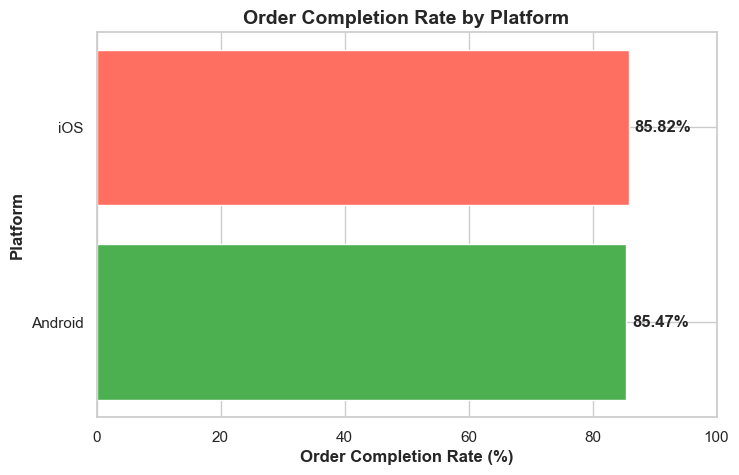

In [290]:
import matplotlib.pyplot as plt

# Count total and successful orders per platform
total_orders_platform = df.groupby('platform')['final_order_status'].count()
successful_orders_platform = df[df['final_order_status'] == 'successful'].groupby('platform')['final_order_status'].count()

# Calculate order completion rate per platform
order_completion_rate_platform = (successful_orders_platform / total_orders_platform) * 100

# Print results
for platform, rate in order_completion_rate_platform.items():
    print(f"🔹 {platform} Order Completion Rate: {rate:.2f}% ({successful_orders_platform[platform]}/{total_orders_platform[platform]})")

# Convert to DataFrame for visualization
order_completion_df = order_completion_rate_platform.reset_index()
order_completion_df.columns = ['Platform', 'Order Completion Rate (%)']

# Visualize as a **Horizontal Bar Chart**
plt.figure(figsize=(8, 5))
plt.barh(order_completion_df['Platform'], order_completion_df['Order Completion Rate (%)'], color=['#4CAF50', '#FF6F61'])

# Add labels on the bars
for index, value in enumerate(order_completion_df['Order Completion Rate (%)']):
    plt.text(value + 1, index, f"{value:.2f}%", va='center', fontsize=12, fontweight='bold')

# Title and labels
plt.title("Order Completion Rate by Platform", fontsize=14, fontweight='bold')
plt.xlabel("Order Completion Rate (%)", fontsize=12, fontweight='bold')
plt.ylabel("Platform", fontsize=12, fontweight='bold')
plt.xlim(0, 100)

# Show plot
plt.show()

# Conversion Rate by Platform

🔹 Android Conversion Rate: 36.15%
🔹 iOS Conversion Rate: 39.87%


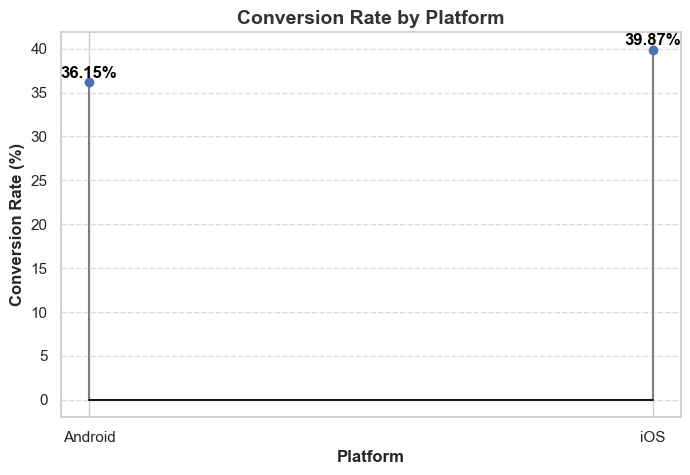

In [298]:
import matplotlib.pyplot as plt
import numpy as np

# Count total users per platform
total_users_platform = df.groupby('platform')['user_id'].nunique()

# Count successful conversions per platform
successful_users_platform = df[df['final_order_status'] == 'successful'].groupby('platform')['user_id'].nunique()

# Calculate conversion rate per platform
conversion_rate_platform = (successful_users_platform / total_users_platform) * 100

# Convert to DataFrame
conversion_df = conversion_rate_platform.reset_index()
conversion_df.columns = ['Platform', 'Conversion Rate (%)']

# Print results
for index, row in conversion_df.iterrows():
    print(f"🔹 {row['Platform']} Conversion Rate: {row['Conversion Rate (%)']:.2f}%")

# Visualize - Lollipop Chart
plt.figure(figsize=(8, 5))
plt.stem(conversion_df["Platform"], conversion_df["Conversion Rate (%)"], 
         linefmt='gray', markerfmt='bo', basefmt="k")  # Gray lines, blue dots

# Add labels for each point
for i, txt in enumerate(conversion_df["Conversion Rate (%)"]):
    plt.text(conversion_df["Platform"][i], txt + 0.5, f"{txt:.2f}%", ha='center', fontsize=12, fontweight='bold', color='black')

# Title and Labels
plt.title("Conversion Rate by Platform", fontsize=14, fontweight='bold', color="#333")
plt.xlabel("Platform", fontsize=12, fontweight='bold')
plt.ylabel("Conversion Rate (%)", fontsize=12, fontweight='bold')
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

# Grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show Plot
plt.show()

# Kaplan-Meier Survival Analysis 

In [304]:
!pip install lifelines

  Preparing metadata (setup.py) ... done
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=1a1aee8f0869f57ffeef8f2c49ec13c64a65f37bdda06961abbd3c98bac8377a
  Stored in directory: /Users/amansai/Library/Caches/pip/wheels/50/37/21/0a719b9d89c635e89ff24bd93b862882ad675279552013b2fb
Successfully built autograd-gamma


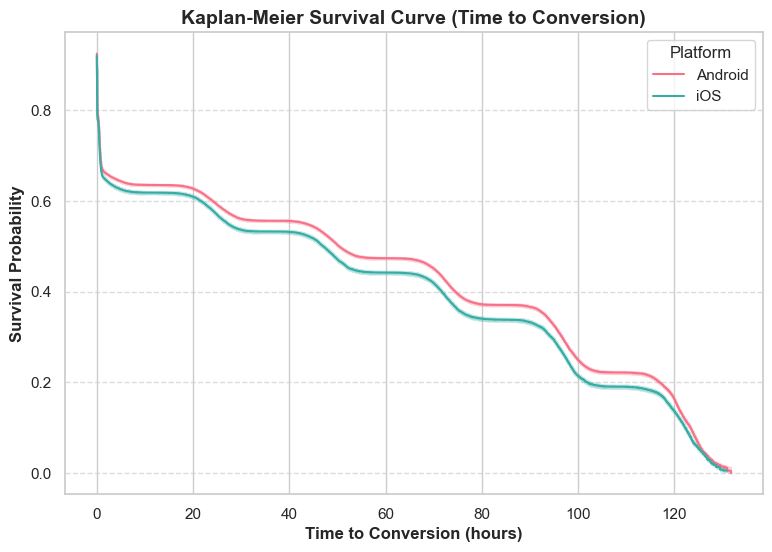


🔹 **Kaplan-Meier Survival Probabilities (Time to Conversion):**

📌 **Platform: Android**
   - 1 Hour: 67.5% users still unconverted
   - 6 Hours: 64.0% users still unconverted
   - 24 Hours: 60.1% users still unconverted
----------------------------------------
📌 **Platform: iOS**
   - 1 Hour: 66.2% users still unconverted
   - 6 Hours: 62.3% users still unconverted
   - 24 Hours: 58.0% users still unconverted
----------------------------------------


In [310]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter

# Step 1: Prepare Data
df['datetime_event'] = pd.to_datetime(df['datetime_event'])  # Ensure datetime format

# Get the first event time per user
first_event_time = df.groupby('user_id')['datetime_event'].min().reset_index()
first_event_time.columns = ['user_id', 'first_event_time']

# Merge with original DataFrame
df = df.merge(first_event_time, on='user_id', how='left')

# Calculate time to conversion (in hours)
df['time_to_conversion'] = (df['datetime_event'] - df['first_event_time']).dt.total_seconds() / 3600

# Create event column: 1 if successful conversion, 0 otherwise
df['event'] = df['final_order_status'].apply(lambda x: 1 if x == 'successful' else 0)

# Step 2: Kaplan-Meier Survival Analysis by Platform
kmf = KaplanMeierFitter()

plt.figure(figsize=(9, 6))
colors = sns.color_palette("husl", len(df['platform'].unique()))  # Generate distinct colors

# Dictionary to store survival probabilities
survival_results = {}

for i, platform in enumerate(df['platform'].unique()):
    platform_data = df[df['platform'] == platform]
    
    kmf.fit(platform_data['time_to_conversion'], event_observed=platform_data['event'], label=platform)
    
    # Store survival probability at key time points
    survival_results[platform] = {
        "1 Hour": round(kmf.survival_function_at_times([1]).values[0], 3),
        "6 Hours": round(kmf.survival_function_at_times([6]).values[0], 3),
        "24 Hours": round(kmf.survival_function_at_times([24]).values[0], 3)
    }
    
    kmf.plot_survival_function(ci_show=True, color=colors[i])  # Enable confidence interval shading

# Step 3: Styling the Plot
plt.title("Kaplan-Meier Survival Curve (Time to Conversion)", fontsize=14, fontweight='bold')
plt.xlabel("Time to Conversion (hours)", fontsize=12, fontweight='bold')
plt.ylabel("Survival Probability", fontsize=12, fontweight='bold')
plt.legend(title="Platform")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.show()

# Step 4: Print Results in a Structured Format
print("\n🔹 **Kaplan-Meier Survival Probabilities (Time to Conversion):**\n")
for platform, times in survival_results.items():
    print(f"📌 **Platform: {platform}**")
    for time, probability in times.items():
        print(f"   - {time}: {probability * 100:.1f}% users still unconverted")
    print("-" * 40)